# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import cv2
import tensorflow as tf
from tensorflow import keras

In [2]:
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/retinal-rec/Datasets/APTOS2019'
TRAIN_PATH = DATASET_PATH + "/train_images/"
TEST_PATH = DATASET_PATH + "/test_images/"
TRAIN_PREP_PATH = DATASET_PATH + "/train_preprocessed/"
N_CLASSES = 5
IMG_SIZE = (512, 512)


In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(TRAIN_PREP_PATH):
  os.mkdir(TRAIN_PREP_PATH)

Mounted at /content/drive
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/retinal-rec/Datasets/APTOS2019


## Display one image from each class

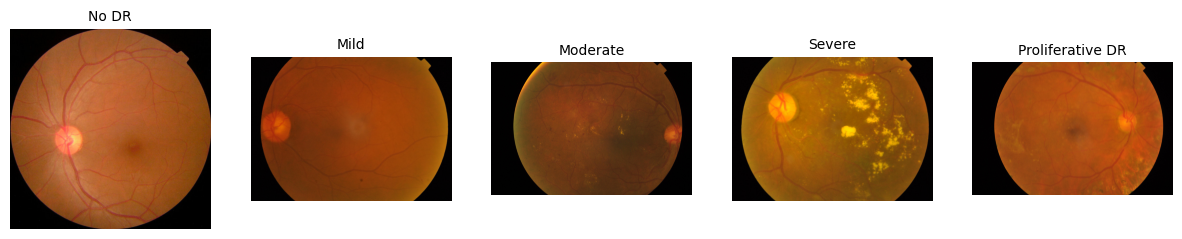

In [4]:
# Read labels
train = pd.read_csv(DATASET_PATH + "/train.csv")
test = pd.read_csv(DATASET_PATH + "/test.csv")

# Adjust figure sizes before display
plt.rcParams['figure.figsize'] = [15, 15] 
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['axes.titlesize'] = 10

# Instantiate plot
fig, ax = plt.subplots(1,5) 

classes = [ "No DR", "Mild", "Moderate", "Severe", "Proliferative DR" ]

for i in range(N_CLASSES):
  row = train.query("diagnosis ==" + str(i))
  img = cv2.imread(TRAIN_PATH + row["id_code"].values[0] + ".png")

  # cv2.COLOR_BGR2RGB is specified as CV2 utilises BGR, but our original image is RGB 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax[i].imshow(img) 
  ax[i].set_title(classes[i]) 
  ax[i].axis('off')
    

# Preprocessing

It is true that the background contrast has improved after histogram equalization. But compare the face of statue in both images. We lost most of the information there due to over-brightness. It is because its histogram is not confined to a particular region as we saw in previous cases (Try to plot histogram of input image, you will get more intuition).

So to solve this problem, adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

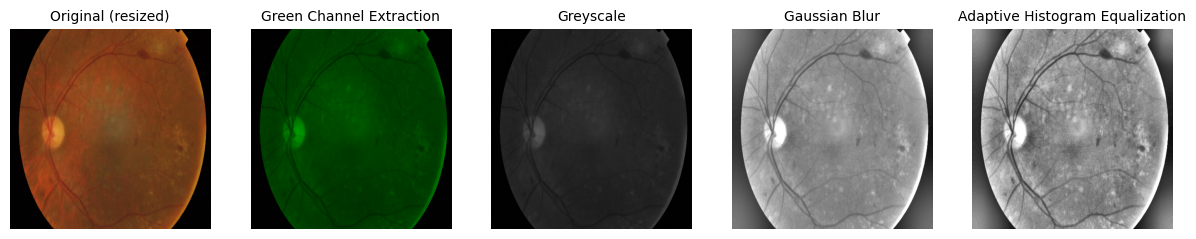

In [8]:
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook

def preprocess(id_code):

  fig, ax = plt.subplots(1,5) 

  img = cv2.imread(TRAIN_PATH + id_code + ".png")

  # Resize the image
  img = cv2.resize(img, IMG_SIZE)

  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[0].set_title("Original (resized)") 
  ax[0].axis('off')

  # Extract Green Channel
  img[:,:,0] = 0
  img[:,:,2] = 0

  ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[1].set_title("Green Channel Extraction") 
  ax[1].axis('off')

  # Convert to Greyscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ax[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[2].set_title("Greyscale") 
  ax[2].axis('off')

  # Apply Gaussian Blur
  img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , 512/10) ,-4 ,128)
  
  ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[3].set_title("Gaussian Blur") 
  ax[3].axis('off')

  # Perform histogram equalization

  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img = clahe.apply(img)

  ax[4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[4].set_title("Adaptive Histogram Equalization") 
  ax[4].axis('off')

  #cv2.imwrite(TRAIN_PREP_PATH + id_code + ".png", img)


preprocess("03c85870824c") # Level 3

#for id_code in train["id_code"]:
 # preprocess(id_code) 